In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with quantum simulation of the Hubbard model

This notebook demonstrates quantum simulation of the Hubbard model using the variational quantum eigensolver (VQE). The Hubbard model is the Hamiltonian for a broad class of materials called strongly correlated electron systems, which include a wide variety of industry-relevant materials. For this notebook, the relevant use case for simulating the Hubbard model is 2D transition metal dichalcogenides, which are used in batteries, semiconductor chips, electric vehicles, and quantum sensors. 

The basic workflow for this quantum simulation includes the following main steps: 
1. Identify the system of interest, which can be a material, a molecular system, or a biological system. 
2. Write down the relevant Hamiltonian, typically in second quantization notation.
3. Using the Hamiltonian mapping, convert the Hamiltonian into quantum gates.
4. Identify the relevant properties of the Hamiltonian.
5. Choose the suitable variational quantum algorithm for the calculation of the properties of interest.
6. Calculate the metrics for accuracy and performace, and then benchmark with classical models.
7. Include the noise models to evaluate the effects of noise on the quantum simulation.
8. Finally, run the algorithm on quantum hardware, for which suitable error mitigation schemes need to be included.

Here, the system of interest is represented as the 2D Hubbard model. First, we explore ways to construct the Hubbard model on different kinds of lattices. Then, we take the Hamiltonian and, using Jordan-Wigner mapping, we construct the qubit version of the Hubbard model. This model is then passed on to the VQE solver for calculating its ground state. We also run classical benchmarks with the exact diagonalization method to determine the consistency of our results. 

### Introduction to the Hubbard model

One of the most promising applications of quantum computing is the quantum simulation of physical, chemical, and biological systems—specifically, the simulation of materials, medicines, catalysts, and biomolecules. Most of the industrially relevant materials exhibit strong correlation effects and are described by lattice models such as the quantum Ising model, Heisenberg model, periodic Anderson model, and Hubbard model. The Hubbard model has been studied extensively in relation to high-temperature superconductors, where the parent material is a two-dimensional transition metal oxide, and found to capture some of the most essential aspects of this material’s phase diagram. 

While the Hubbard model has been explored at length using classical computational techniques—notably, quantum Monte Carlo, exact diagonalization, and dynamical mean-field theory combined with different quantum impurity solvers—all of these classical computational methods face a bottleneck created by the exponential blow-up of the Hilbert space as the system size increases. For this reason, there has been a lot of focus recently on using quantum computers to simulate the Hubbard model. The main quantum algorithm that has been used to explore the Hubbard model is VQE, which calculates the ground state, excited states, and other interesting dynamical and spectral properties. In this notebook, we will explore the Hubbard model using the VQE algorithm.

The Hubbard model is a fermonic lattice model, which in its basic form has two terms. The first one is the hopping term, which represents the movement of electrons from one site to next site on the lattice. The second term is the local interaction, which represents the onsite replusion between electrons. In second quantization notation, the Hubbard model on a one-dimensional lattice with $N$ sites having nearest-neighbor hopping and on-site interactions only can be written as follows:
$$
\begin{align*}
H &= \sum_{i = 0}^{N-1} \sum_{\sigma = \uparrow, \downarrow} (t c_{i, \sigma}^\dagger c_{i+1, \sigma} + t c_{i+1, \sigma}^\dagger c_{i, \sigma})+ U \sum_{i=0}^{N-1} n_{i, \uparrow} n_{i, \downarrow}+\nu \sum_{i=0}^{N-1}\sum_{\sigma = \uparrow, \downarrow}c_{i\sigma}^{\dagger}c_{i\sigma} \\
\end{align*}
$$

For the specific case of four sites, the Hubbard Hamiltonian can be explicity written down as follows:

$$
\begin{align*}
H &= t c_{0, \uparrow}^\dagger c_{1, \uparrow} + t c_{0, \uparrow} c_{1, \uparrow}^{\dagger} 
  + t c_{1, \uparrow}^\dagger c_{2, \uparrow} + t c_{1, \uparrow} c_{2, \uparrow}^{\dagger} \\
& \ + t c_{2, \uparrow}^\dagger c_{3, \uparrow} + t c_{2, \uparrow} c_{3, \uparrow}^{\dagger} 
 + v n_{0, \uparrow} + v n_{1, \uparrow} + v n_{2, \uparrow} + v n_{3, \uparrow} 
+ t c_{0, \downarrow}^\dagger c_{1, \downarrow} +t c_{0, \downarrow} c_{1, \downarrow}^{\dagger} \\
& \ + t c_{1, \downarrow}^\dagger c_{2, \downarrow} + t c_{1, \downarrow} c_{2, \downarrow}^{\dagger} 
+ t c_{2, \downarrow}^\dagger c_{3, \downarrow} + t c_{2, \downarrow} c_{3, \downarrow}^{\dagger} \\
& \ + v n_{0, \downarrow} + v n_{1, \downarrow} + v n_{2, \downarrow} + v n_{3, \downarrow}  + U n_{0, \uparrow} n_{0, \downarrow} + U n_{1, \uparrow} n_{1, \downarrow}  + U n_{2, \uparrow} n_{2, \downarrow} + U n_{3, \uparrow} n_{3, \downarrow}
\end{align*}
$$

### Set up a general lattice in Qiskit Nature

For the quantum simulation of the Hubbard model, we will use the Qiskit Nature module. Because the Hubbard model is a lattice model, the underlying lattice is important for the physics of this model. There are many choices for the lattice and the dimensionality of the space in which the lattice is defined. First, we need to learn how to set up the lattice of interest in Qiskit. Then, we need to associate fermionic operators with the edges and vertices of the lattice to define the Hubbard model on the given lattice. 

In [2]:
import rustworkx as rx
import numpy as np
from math import pi

from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians.fermi_hubbard_model import FermiHubbardModel

Once the Hubbard model has been defined on a given lattice, we need to map to qubit representation using fermion-to-qubit mapping so that we can calculate the ground state and other properties using quantum variational algorithms such as the variational quantum eigensolver (VQE).

The `lattice_models` module of Qiskit Nature allows us to use different lattices in various dimensions. In what follows, we will first write Qiskit code to define different types of lattices on which we will later write down Hubbard models. First, we start with the general type of lattice, and then we proceed to more specific types of lattices, including more interesting ones like two-dimensional and three-dimensional lattices. 

In [3]:
graph = rx.PyGraph(multigraph=False)  # multiigraph shoud be False
graph.add_nodes_from(range(6))
weighted_edge_list = [
    (0, 1, 1.0 + 1.0j),
    (0, 2, -1.0),
    (2, 3, 2.0),
    (4, 2, -1.0 + 2.0j),
    (4, 4, 3.0),
    (2, 5, -1.0),
]
graph.add_edges_from(weighted_edge_list)

# make a lattice
general_lattice = Lattice(graph)
set(general_lattice.graph.weighted_edge_list())

{(0, 1, (1+1j)),
 (0, 2, -1.0),
 (2, 3, 2.0),
 (2, 5, -1.0),
 (4, 2, (-1+2j)),
 (4, 4, 3.0)}

#### Visualize the lattice

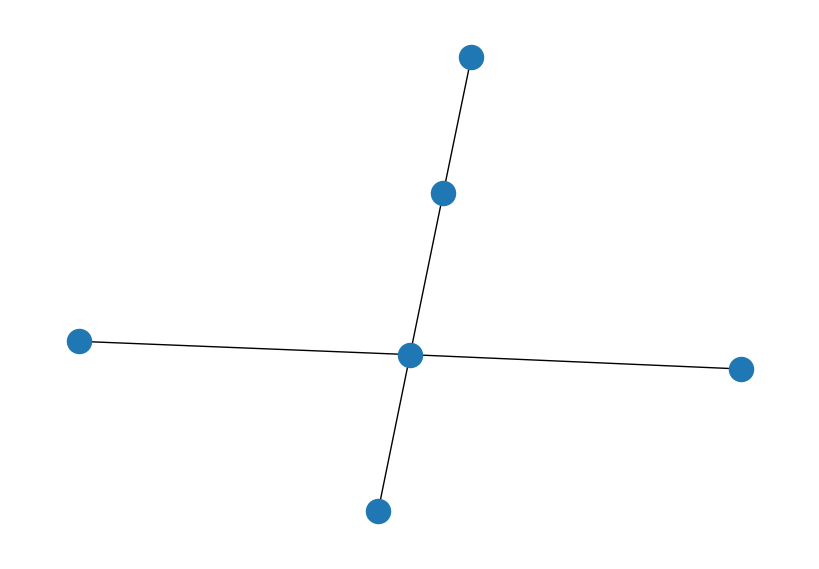

In [4]:
general_lattice.draw()

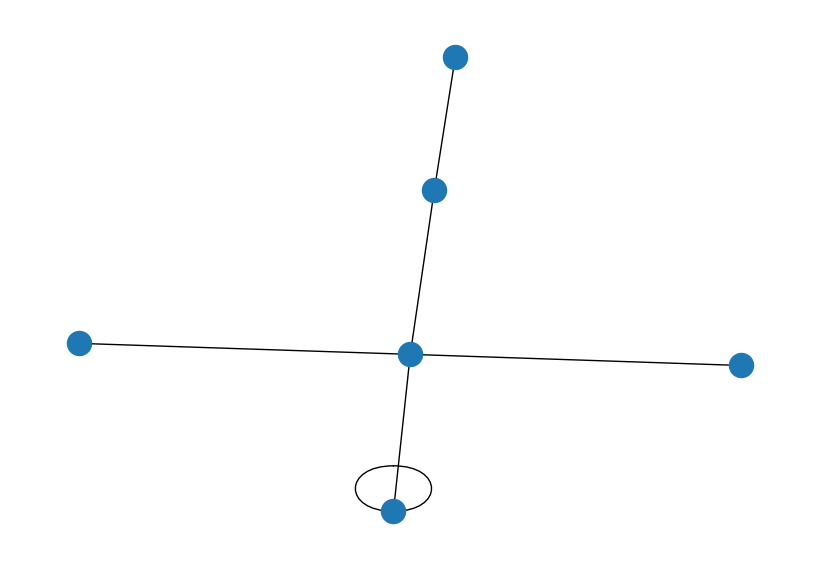

In [5]:
general_lattice.draw(self_loop=True)

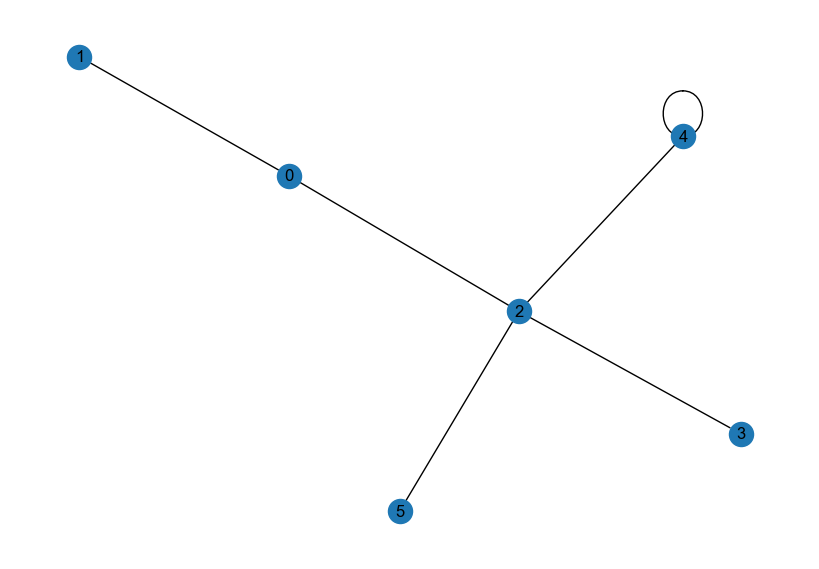

In [6]:
general_lattice.draw(self_loop=True, style=LatticeDrawStyle(with_labels=True))

#### Specify the lattice parameters

The Hubbard model has three parameters that need to be specified. The first is the hopping parameter ($t$), which determines the hopping strength of the electrons and quantifies how much kinetic energy the electrons have to hop from one lattice site to the next. The second is the onsite Hubbard interaction parameter ($U$), which quantifies the strength of the local Hubbard interaction between electrons on the same lattice site. The third is the chemical potential, which quantifies the onsite energy of electrons. For the sake of simplicity, the chemical potential is set to zero in many cases. In our implementation, the hopping parameters are associated with the edges of the graph and hence are encoded in the adjacency matrix. The Hubbard interaction parameter is associated with the nodes of the graph.

##### Encode the hopping parameters in the adjacency matrix (hopping matrix) $t_{x, y}$

In [7]:
general_lattice.to_adjacency_matrix()

array([[0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]])

##### Define the Hubbard model on the lattice

To define the Hubbard model on a given lattice, we can use the `FermiHubbardModel` class from Qiskit Nature. We need to specify the type of lattice and the onsite interaction parameter, and we will obtain the hopping parameters from the adjacency matrix of the graph.

In [8]:
onsite_interaction = 2.0

fhm = FermiHubbardModel(
    lattice=general_lattice,
    onsite_interaction=onsite_interaction
)

ham = fhm.second_q_op()

# Even site -> up spin
# Odd sites -> down spin
print(ham)

Fermionic Operator
number spin orbitals=12, number terms=28
  (1+1j) * ( +_0 -_2 )
+ (-1+1j) * ( -_0 +_2 )
+ -1.0 * ( +_0 -_4 )
+ 1.0 * ( -_0 +_4 )
+ 2.0 * ( +_4 -_6 )
+ -2.0 * ( -_4 +_6 )
+ (-1-2j) * ( +_4 -_8 )
+ (1-2j) * ( -_4 +_8 )
+ 3.0 * ( +_8 -_8 )
+ -1.0 * ( +_4 -_10 )
+ 1.0 * ( -_4 +_10 )
+ (1+1j) * ( +_1 -_3 )
+ (-1+1j) * ( -_1 +_3 )
+ -1.0 * ( +_1 -_5 )
+ 1.0 * ( -_1 +_5 )
+ 2.0 * ( +_5 -_7 )
+ -2.0 * ( -_5 +_7 )
+ (-1-2j) * ( +_5 -_9 )
+ (1-2j) * ( -_5 +_9 )
+ 3.0 * ( +_9 -_9 )
+ -1.0 * ( +_5 -_11 )
+ 1.0 * ( -_5 +_11 )
+ 2.0 * ( +_0 -_0 +_1 -_1 )
+ 2.0 * ( +_2 -_2 +_3 -_3 )
+ 2.0 * ( +_4 -_4 +_5 -_5 )
+ 2.0 * ( +_6 -_6 +_7 -_7 )
+ 2.0 * ( +_8 -_8 +_9 -_9 )
+ 2.0 * ( +_10 -_10 +_11 -_11 )


In [9]:
fhm.hopping_matrix()

array([[ 0.+0.j,  1.+1.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 1.-1.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [-1.+0.j,  0.+0.j,  0.+0.j,  2.+0.j, -1.+2.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j,  2.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.-2.j,  0.+0.j,  3.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

### Set up different types of lattices 

#### One-dimensional lattice

For the lattice model, we also need to specify the boundary conditions—either open or periodic. For the higher-dimensional lattices, we can use mixed types of boundary conditions with both open and periodic boundary conditions. Qiskit Nature supports both of them. For the lattice type, we can choose from various dimensions typically ranging from one to three. In the following code cell, we choose open boundary conditions for a one-dimensional lattice. 

In [10]:
# In this cell, we define the hopping parameter at the level of the lattice itself.
lattice_points = 2
t = 1.0
onsite_potential = 1.0
one_dim_lattice = LineLattice(
    num_nodes=lattice_points,
    edge_parameter=t,
    onsite_parameter=onsite_potential,
    boundary_condition=BoundaryCondition.OPEN
)

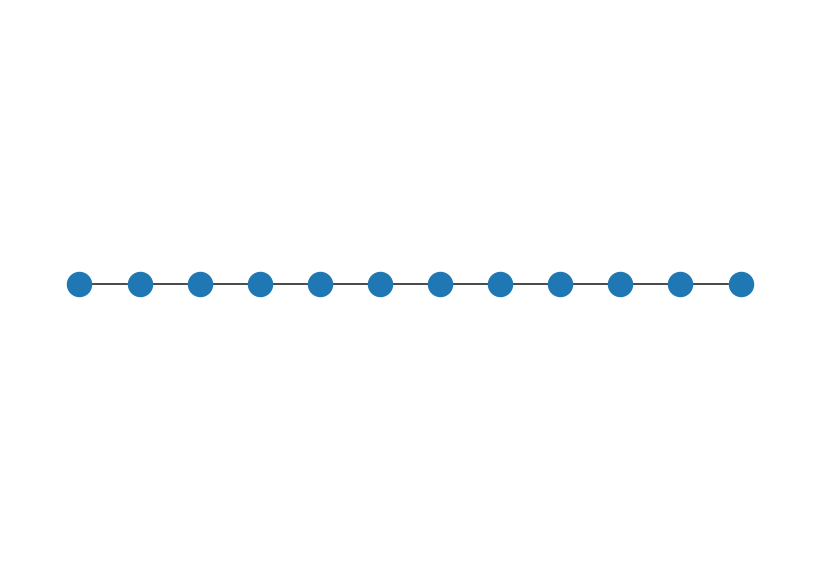

In [11]:
num_nodes = 12
boundary_condition = BoundaryCondition.OPEN
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)
line_lattice.draw()

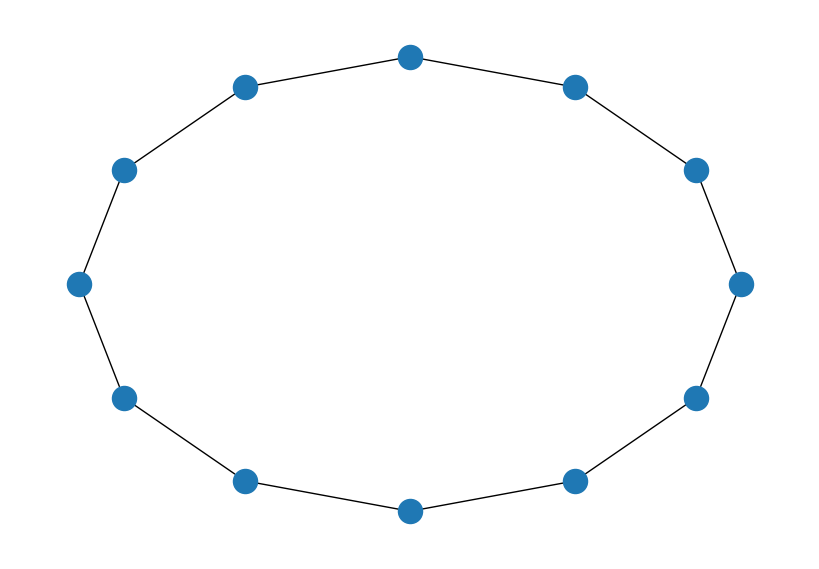

In [12]:
num_nodes = 12
boundary_condition = BoundaryCondition.PERIODIC
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)

line_lattice.draw()

In [13]:
num_nodes = 11
boundary_condition = BoundaryCondition.PERIODIC
edge_parameter = 1.0 + 1.0j
onsite_parameter = 1.0
line_lattice = LineLattice(
    num_nodes=num_nodes,
    edge_parameter=edge_parameter,
    onsite_parameter=onsite_parameter,
    boundary_condition=boundary_condition,
)
set(line_lattice.graph.weighted_edge_list())

{(0, 0, 1.0),
 (0, 1, (1+1j)),
 (0, 10, (1-1j)),
 (1, 1, 1.0),
 (1, 2, (1+1j)),
 (2, 2, 1.0),
 (2, 3, (1+1j)),
 (3, 3, 1.0),
 (3, 4, (1+1j)),
 (4, 4, 1.0),
 (4, 5, (1+1j)),
 (5, 5, 1.0),
 (5, 6, (1+1j)),
 (6, 6, 1.0),
 (6, 7, (1+1j)),
 (7, 7, 1.0),
 (7, 8, (1+1j)),
 (8, 8, 1.0),
 (8, 9, (1+1j)),
 (9, 9, 1.0),
 (9, 10, (1+1j)),
 (10, 10, 1.0)}

In [14]:
line_lattice.to_adjacency_matrix()

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])

In [15]:
line_lattice.to_adjacency_matrix(weighted=True)

array([[1.+0.j, 1.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 1.-1.j],
       [1.-1.j, 1.+0.j, 1.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.-1.j, 1.+0.j, 1.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.-1.j, 1.+0.j, 1.+1.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.-1.j, 1.+0.j, 1.+1.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.-1.j, 1.+0.j, 1.+1.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.-1.j, 1.+0.j, 1.+1.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.-1.j, 1.+0.j,
        1.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.-1.j,
        1.+0.j, 1.+1.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,

#### Square lattice

Two-dimensional lattices are very important from a real materials perspective, as many interesting materials such as semiconductors, high-temperature superconductors, and quantum Hall fluids effectively have two-dimensional geometries. One of the most extensively used lattices for two-dimensional cases is the square lattice. 

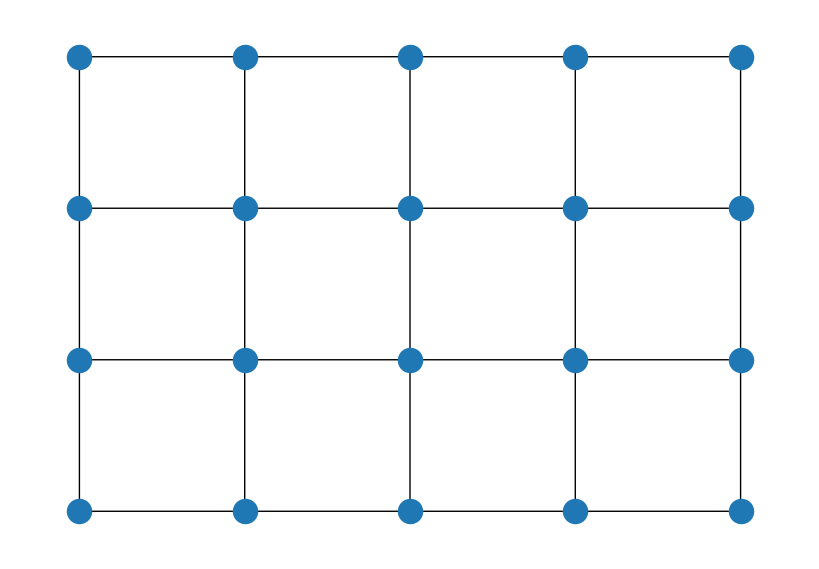

In [16]:
rows = 5
cols = 4
boundary_condition = BoundaryCondition.OPEN
square_lattice = SquareLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)

square_lattice.draw()

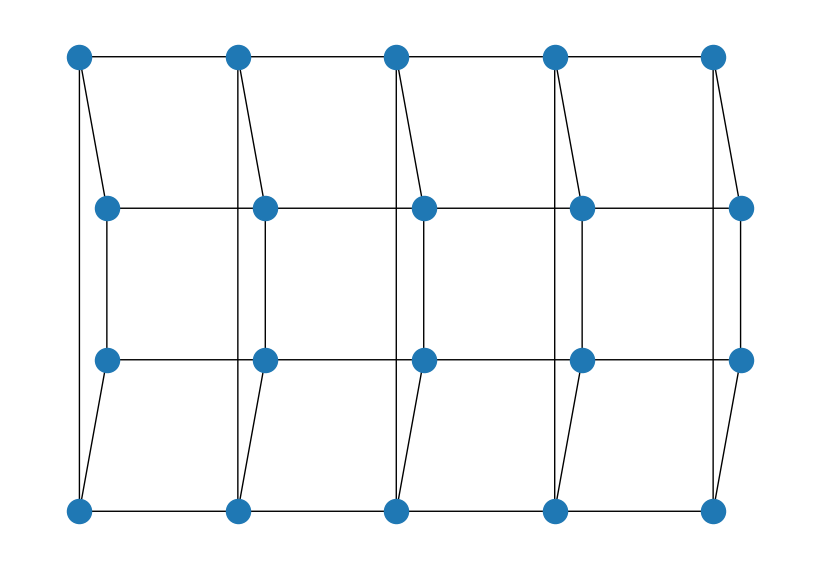

In [17]:
rows = 5
cols = 4
boundary_condition = (
    BoundaryCondition.OPEN,
    BoundaryCondition.PERIODIC,
)  # open in the x-direction, periodic in the y-direction
square_lattice = SquareLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)

square_lattice.draw()

#### Triangular lattice

In some real materials, the lattice geometry is triangular, so we have considered this type of lattice as well. 

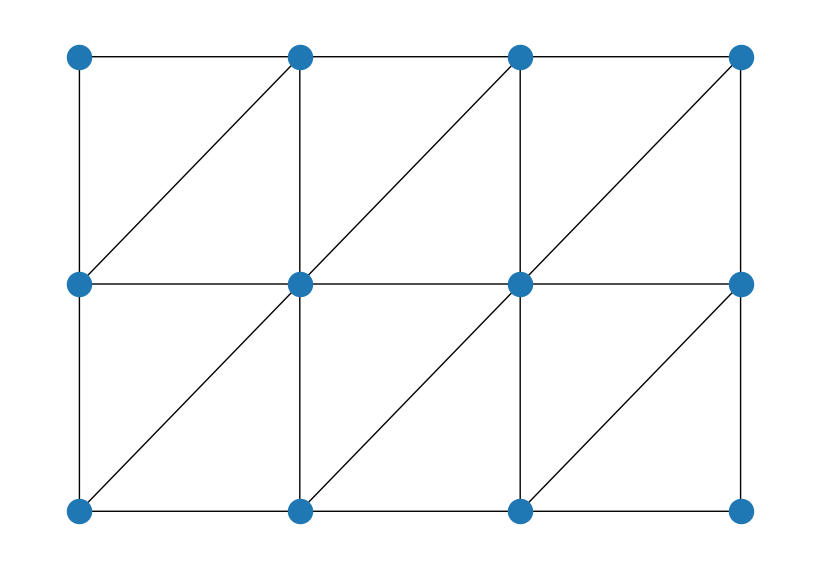

In [18]:
rows = 4
cols = 3
boundary_condition = BoundaryCondition.OPEN

triangular_lattice = TriangularLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)

triangular_lattice.draw()

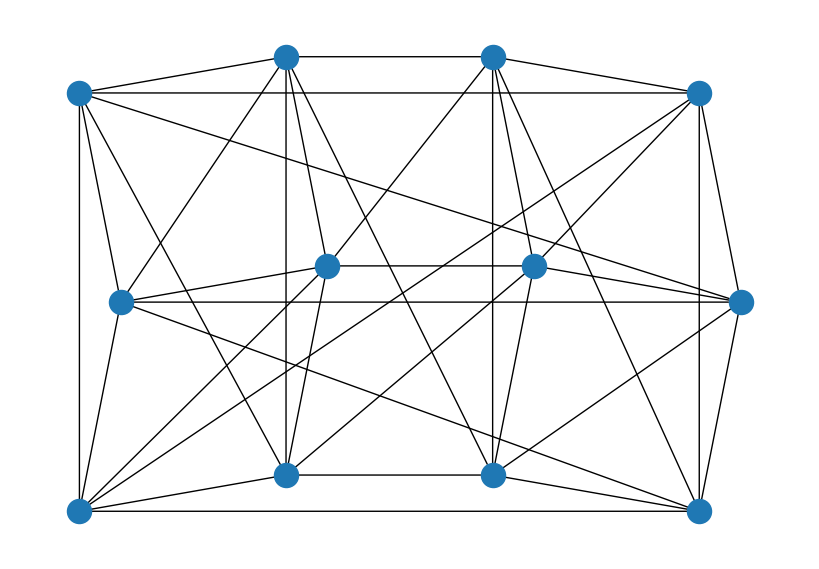

In [19]:
rows = 4
cols = 3
boundary_condition = BoundaryCondition.PERIODIC

triangular_lattice = TriangularLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)

triangular_lattice.draw()

### Hypercubic lattice

Three-dimensional lattices are the most relevant lattice type for real materials. One of the most widely explored three-dimensional lattice types is the hypercubic lattice.

In [20]:
size = (3, 4, 5)
boundary_condition = (
    BoundaryCondition.OPEN,
    BoundaryCondition.OPEN,
    BoundaryCondition.OPEN,
)
cubic_lattice = HyperCubicLattice(size=size, boundary_condition=boundary_condition)

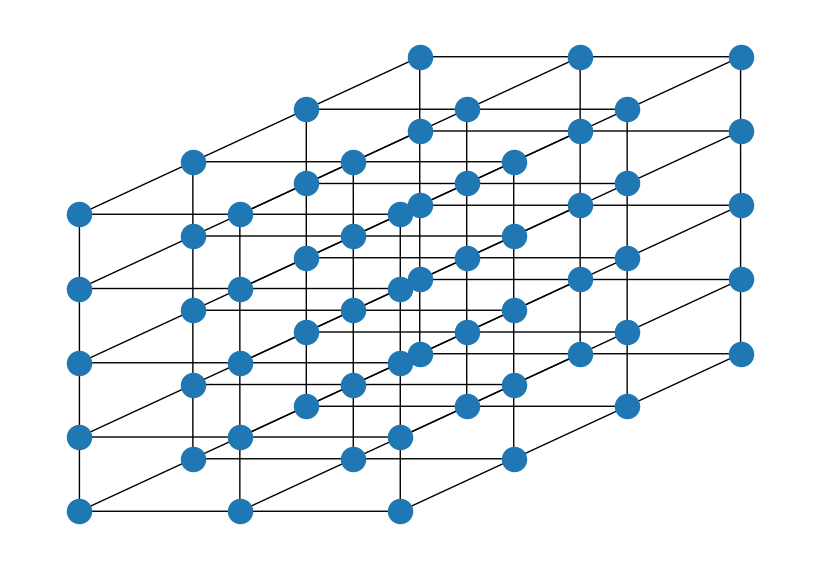

In [21]:
# Function for setting the positions
def indextocoord_3d(index: int, size: tuple, angle) -> list:
    z = index // (size[0] * size[1])
    a = index % (size[0] * size[1])
    y = a // size[0]
    x = a % size[0]
    vec_x = np.array([1, 0])
    vec_y = np.array([np.cos(angle), np.sin(angle)])
    vec_z = np.array([0, 1])
    return_coord = x * vec_x + y * vec_y + z * vec_z
    return return_coord.tolist()


pos = dict([(index, indextocoord_3d(index, size, angle=pi / 4)) for index in range(np.prod(size))])

cubic_lattice.draw(style=LatticeDrawStyle(pos=pos))

### Set parameters for the Hubbard model

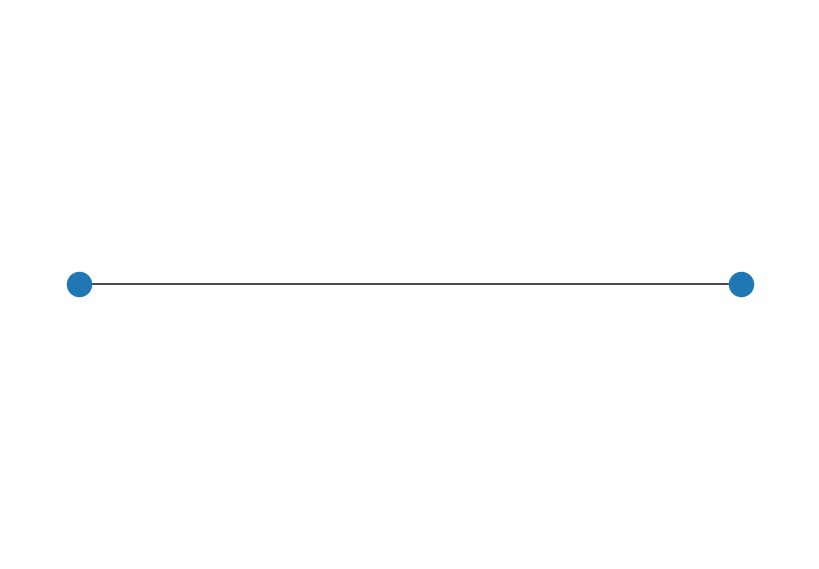

In [22]:
lattice_points = 2
t = 1.0
onsite_potential = 0.1
one_dim_lattice = LineLattice(
    num_nodes=lattice_points,
    edge_parameter=t,
    onsite_parameter=onsite_potential,
    boundary_condition=BoundaryCondition.OPEN
)

#pos = {0:[0, 0], 1:[1, 0], 2:[2, 0], 3:[3, 0]}
one_dim_lattice.draw()

In [23]:
onsite_interaction=2.0
fhm = FermiHubbardModel(
    one_dim_lattice,
    onsite_interaction
)

ham_2site = fhm.second_q_op()
print('Hamiltonian:',ham)
#print('Hopping matrix:',fhm.hopping_matrix())

Hamiltonian: Fermionic Operator
number spin orbitals=12, number terms=28
  (1+1j) * ( +_0 -_2 )
+ (-1+1j) * ( -_0 +_2 )
+ -1.0 * ( +_0 -_4 )
+ 1.0 * ( -_0 +_4 )
+ 2.0 * ( +_4 -_6 )
+ -2.0 * ( -_4 +_6 )
+ (-1-2j) * ( +_4 -_8 )
+ (1-2j) * ( -_4 +_8 )
+ 3.0 * ( +_8 -_8 )
+ -1.0 * ( +_4 -_10 )
+ 1.0 * ( -_4 +_10 )
+ (1+1j) * ( +_1 -_3 )
+ (-1+1j) * ( -_1 +_3 )
+ -1.0 * ( +_1 -_5 )
+ 1.0 * ( -_1 +_5 )
+ 2.0 * ( +_5 -_7 )
+ -2.0 * ( -_5 +_7 )
+ (-1-2j) * ( +_5 -_9 )
+ (1-2j) * ( -_5 +_9 )
+ 3.0 * ( +_9 -_9 )
+ -1.0 * ( +_5 -_11 )
+ 1.0 * ( -_5 +_11 )
+ 2.0 * ( +_0 -_0 +_1 -_1 )
+ 2.0 * ( +_2 -_2 +_3 -_3 )
+ 2.0 * ( +_4 -_4 +_5 -_5 )
+ 2.0 * ( +_6 -_6 +_7 -_7 )
+ 2.0 * ( +_8 -_8 +_9 -_9 )
+ 2.0 * ( +_10 -_10 +_11 -_11 )


### Apply the VQE to the Hubbard model

Now that we have set up the Hubbard model on different kinds of lattices, we will apply the variational quantum eigensolver to the Hubbard model and calculate its ground state energy. We will benchmark our results with numerical exact diagonalization of the Hubbard model and see how well VQE is performing for the Hubbard model. For that, we first need to map fermionic operators present in the Hubbard model onto the qubit operators. There are already some fermion-to-qubit mappings that can be used for this purpose. We will use one of the popular mappings called the Jordan-Wigner mapping. After the Jordan-Wigner mapping, the Hamiltonian is represented in terms of Pauli operators/gates.

In [24]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature import settings

settings.use_pauli_sum_op = False



In [25]:
mapper = JordanWignerMapper()

qubit_op_2site = mapper.map(ham_2site)

print('num_qubits:',qubit_op_2site.num_qubits)
print('qubit_op:\n',qubit_op_2site)

num_qubits: 4
qubit_op:
 SparsePauliOp(['IYZY', 'IXZX', 'IIII', 'IIIZ', 'IZII', 'YZYI', 'XZXI', 'IIZI', 'ZIII', 'IIZZ', 'ZZII'],
              coeffs=[ 0.5 +0.j,  0.5 +0.j,  1.2 +0.j, -0.55+0.j, -0.55+0.j,  0.5 +0.j,
  0.5 +0.j, -0.55+0.j, -0.55+0.j,  0.5 +0.j,  0.5 +0.j])


num_parameters: 32
circuit_depth: 1
nonlocal gates: 1


/Users/iuliazidaru/opt/anaconda3/envs/202311_2d/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


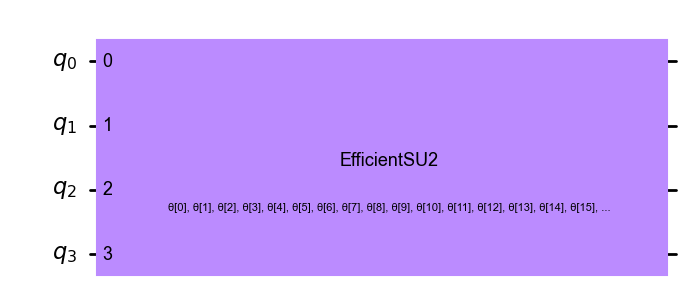

In [26]:
from qiskit_algorithms.minimum_eigensolvers       import VQE
from qiskit_algorithms.optimizers                 import L_BFGS_B,COBYLA, SLSQP
from qiskit.circuit.library                       import TwoLocal, EfficientSU2
from qiskit.primitives                            import Estimator

estimator = Estimator() 
optimizer = COBYLA
ansatz =  EfficientSU2(qubit_op_2site.num_qubits, entanglement="linear")

print('num_parameters:',ansatz.num_parameters)
print('circuit_depth:',ansatz.depth())
print('nonlocal gates:',ansatz.num_nonlocal_gates())

ansatz.draw('mpl')

In [27]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op_2site)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.03607


### Benchmark with classical algorithms

As previously mentioned, the Hubbard model has been explored extensively using classical computational methods. In this section, we will benchmark our results from VQE for the Hubbard model with classical algorithms. 

Exact diagonalization is an important classical method that can be used for benchmarking. We have chosen the `QuSpin` implementation of exact diagonalization. `QuSpin` is a library of quantum lattice models, and it has a nice Python interface. We have benchmarked for different sets of model parameters.

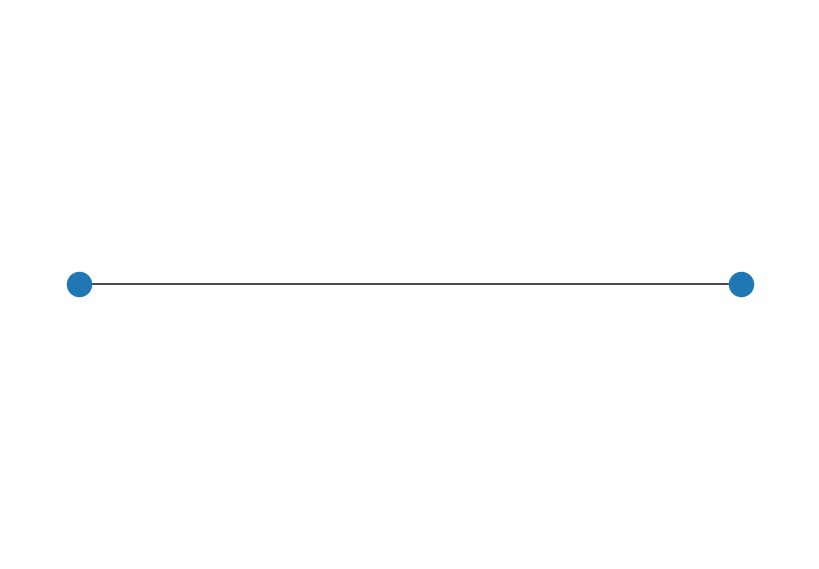

In [28]:
lattice_points = 2
t = 1.0
onsite_potential = 0.1
one_dim_lattice = LineLattice(
    num_nodes=lattice_points,
    edge_parameter=t,
    onsite_parameter=onsite_potential,
    boundary_condition=BoundaryCondition.OPEN
)

#pos = {0:[0, 0], 1:[1, 0], 2:[2, 0], 3:[3, 0]}
one_dim_lattice.draw()

In [29]:
onsite_interaction=2.0
fhm = FermiHubbardModel(
    one_dim_lattice,
    onsite_interaction
)

ham = fhm.second_q_op()
print('Hamiltonian:',ham)
print('Hopping matrix:',fhm.hopping_matrix())

Hamiltonian: Fermionic Operator
number spin orbitals=4, number terms=10
  1.0 * ( +_0 -_2 )
+ -1.0 * ( -_0 +_2 )
+ 0.1 * ( +_0 -_0 )
+ 0.1 * ( +_2 -_2 )
+ 1.0 * ( +_1 -_3 )
+ -1.0 * ( -_1 +_3 )
+ 0.1 * ( +_1 -_1 )
+ 0.1 * ( +_3 -_3 )
+ 2.0 * ( +_0 -_0 +_1 -_1 )
+ 2.0 * ( +_2 -_2 +_3 -_3 )
Hopping matrix: [[0.1+0.j 1. +0.j]
 [1. +0.j 0.1+0.j]]


In [30]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()
settings.use_pauli_sum_op = False

qubit_op_test = mapper.map(ham)

for pauli, coeff in sorted(qubit_op_test.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")
    
print('num_qubits:',qubit_op_test.num_qubits)
print('qubit_op:\n',qubit_op_test)

+1.20000000 * IIII
-0.55000000 * IIIZ
-0.55000000 * IIZI
+0.50000000 * IIZZ
+0.50000000 * IXZX
+0.50000000 * IYZY
-0.55000000 * IZII
+0.50000000 * XZXI
+0.50000000 * YZYI
-0.55000000 * ZIII
+0.50000000 * ZZII
num_qubits: 4
qubit_op:
 SparsePauliOp(['IYZY', 'IXZX', 'IIII', 'IIIZ', 'IZII', 'YZYI', 'XZXI', 'IIZI', 'ZIII', 'IIZZ', 'ZZII'],
              coeffs=[ 0.5 +0.j,  0.5 +0.j,  1.2 +0.j, -0.55+0.j, -0.55+0.j,  0.5 +0.j,
  0.5 +0.j, -0.55+0.j, -0.55+0.j,  0.5 +0.j,  0.5 +0.j])


In [31]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op_test)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.03607


In [ ]:
estimator = Estimator(options={"shots": 1024})
vqe = VQE(estimator, ansatz, optimizer)

vqe.estimator = estimator
vqe.optimizer = L_BFGS_B(maxiter=500)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_test)
print(result)

In [ ]:
# Estimator with shots

estimator = Estimator(options={"shots": 1024})
vqe = VQE(estimator, ansatz, optimizer)

vqe.estimator = estimator
vqe.optimizer = COBYLA(maxiter=1000)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_test)
print(result)

In [ ]:
# Estimator with shots
from qiskit.primitives import Estimator

estimator = Estimator(options={"shots": 1024})
vqe = VQE(estimator, ansatz, optimizer)

vqe.estimator = estimator
vqe.optimizer = COBYLA(maxiter=1500)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_test)
print(result)

In [ ]:
# Estimator with shots
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import SPSA

estimator = Estimator(options={"shots": 2048})
vqe = VQE(estimator, ansatz, optimizer)

vqe.estimator = estimator
vqe.optimizer = SPSA(maxiter=500)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_test)
print(result)

In [ ]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op_test)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

We used the NumPy eigensolver to benchmark VQE for the Hubbard model. As can be seen above, the VQE eigensolver result is very close to the exact diagonalization result from the NumPy eigensolver. The error can be reduced further by choosing a better ansatz such as a unitary coupled cluster, a Hamiltonian variational ansatz, or another. We have selected a hardware-efficient ansatz, which works well for simple molecular Hamiltonians but is not very expressive of the ground state for the Hubbard model. Nevertheless, this ansatz still does a good job of reproducing the exact results.

### Summary

In this notebook, we have demonstrated quantum simulation of the Hubbard model, which is one of the paradigmatic fermionic models for industrially relevant materials, including transition metal oxides. First, we explored how to set up the lattices for one, two, and three dimensions. And then we showed how to define the fermionic Hubbard model on a given lattice. Using the example of the one-dimensional Hubbard model, we used the VQE algorithm to calculate the ground state energy for various lattice sizes and model parameters.

This notebook could easily be adapted to explore the Hubbard model in higher dimensions. As well, in the future this implementation could be extended to calculate spectral, thermodynamic, and transport properties. This would involve the calculation of correlation and response functions for the Hubbard model.

### References 
1. Chris Cade et al. “Stragies for Solving the Fermi-Hubbard Model on Near-Term Quantum Computers.” arXiv:1912.06007, 2019. https://arxiv.org/abs/1912.06007.
2. “The Hubbard Model at Half a Century.” *Nature Physics*, vol. 9 (2013): 523. https://doi.org/10.1038/nphys2759.

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>